In [335]:
## This is a test file to train to track an object
## Author : Avadesh Meduri
## Date : 8/04/2022

from matplotlib import pyplot as plt
import numpy as np

from torch.utils.data import Dataset
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision.io import read_image
from torch.utils.data import DataLoader, RandomSampler, Sampler
import time
import cv2
from PIL import Image
from skimage.io import imread
import numba
from torchvision.transforms import ToTensor, ToPILImage


In [336]:
# %timeit vr[np.random.randint(10)]
def tmp():
    box1 = read_image("./image_data/data1/color_" + str(np.random.randint(100)) + ".jpg")
    box2 = read_image("./image_data/data1/depth_" + str(np.random.randint(100)) + ".jpg")
    box = torch.vstack((box1, box2))
#     box = Image.open("./image_data/data2/" + str(np.random.randint(100)) + ".png")
#     box = (box)
#     print(box.shape)
#     box = imread("./image_data/data2/" + str(np.random.randint(100)) + ".png")
#     image = torch.tensor(box).float()
    
# %timeit tmp()
# %timeit image = imread("./image_data/data1/" + str(np.random.randint(10)) + ".jpg")

# %timeit image = cv2.imread("./image_data/data1/" + str(np.random.randint(10)) + ".jpg")


In [346]:
class BoxDataSet(Dataset):
    
    def __init__(self, fname):
        
        self.img_dir = "./image_data/" + fname
        self.data = np.load("./position_data/" + fname + ".npz")
        self.y_train = torch.tensor(self.data["position"]).float()
    
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        
        c_image = read_image(self.img_dir + "/color_" + str(idx) + ".jpg")
        d_image = read_image(self.img_dir + "/depth_" + str(idx) + ".jpg")
        image = torch.vstack((c_image, d_image))
        label = self.y_train[idx]
        return image.float(), label
    
    def get_data(self, idx):
    
        c_image = read_image(self.img_dir + "/color_" + str(idx) + ".jpg", ImageReadMode.UNCHANGED)
        d_image = read_image(self.img_dir + "/depth_" + str(idx) + ".jpg", ImageReadMode.UNCHANGED)
        image = torch.vstack((c_image, d_image))[None,:,:,:]
        label = self.y_train[idx]
        
        return image, label, c_image

In [347]:
class C_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(293904, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
#         print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [348]:
device = torch.device("cuda")

In [374]:
net = C_Net()
net.load_state_dict(torch.load("./models/cnn1"))
net = net.to(device)
lr = 1.5e-4
eps = 150
print("finished loading")

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = torch.nn.MSELoss() #torch.nn.MSELoss() #torch.nn.HuberLoss()
dl_arr = []
dl_arr.append(DataLoader(BoxDataSet("data1"), batch_size = 128, num_workers = 12))
dl_arr.append(DataLoader(BoxDataSet("data2"), batch_size = 128, num_workers = 12))


for i in range(eps):
    for x_train_batch, y_train_batch in dl_arr[np.random.randint(2)]:
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        print("The iteration number : " + str(i) + " The loss is :" + str(error.cpu().detach().numpy()), end='\r', flush  = True)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        
    if i % 10 == 0:
        torch.save(net.state_dict(), "./models/cnn1")
        
torch.save(net.state_dict(), "./models/cnn1")    

finished loading


KeyboardInterrupt: 

In [448]:
dl = BoxDataSet("data3")
net = C_Net()
net.load_state_dict(torch.load("./models/cnn1"))

<All keys matched successfully>

tensor([[0.4170, 0.0819, 0.4622]]) tensor([ 0.2622, -0.0345,  0.5465]) tensor(0.2112)


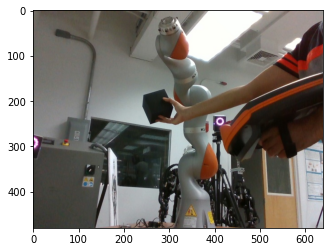

In [454]:
with torch.no_grad():
    img, label, c_image = dl.get_data(np.random.randint(1000))
    pred = net(img.float())
    print(pred, label, torch.linalg.norm(pred - label))
    box = ToPILImage()(img[0][:3])
    plt.imshow(box)

tensor([[[[ 87.,  86.,  88.,  ..., 154., 152., 150.],
          [ 89.,  86.,  87.,  ..., 155., 154., 152.],
          [ 89.,  85.,  85.,  ..., 157., 157., 154.],
          ...,
          [ 62.,  60.,  60.,  ..., 174., 171., 167.],
          [ 61.,  61.,  61.,  ..., 174., 171., 166.],
          [ 59.,  60.,  62.,  ..., 174., 170., 167.]],

         [[ 85.,  84.,  84.,  ..., 164., 163., 161.],
          [ 87.,  84.,  84.,  ..., 165., 164., 164.],
          [ 90.,  86.,  85.,  ..., 165., 164., 164.],
          ...,
          [ 74.,  72.,  73.,  ..., 193., 190., 188.],
          [ 73.,  73.,  74.,  ..., 194., 191., 188.],
          [ 71.,  72.,  75.,  ..., 194., 192., 189.]],

         [[ 72.,  72.,  75.,  ..., 156., 155., 153.],
          [ 74.,  71.,  75.,  ..., 156., 156., 154.],
          [ 74.,  72.,  75.,  ..., 154., 156., 153.],
          ...,
          [ 64.,  62.,  63.,  ..., 189., 186., 183.],
          [ 63.,  63.,  64.,  ..., 192., 189., 185.],
          [ 61.,  62.,  65.,  ...